In [1]:
%load_ext autoreload
%autoreload 2

import optuna
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import numpy as np
import scipy
import seaborn as sns

from steps.prepare_data import load_processed_data, load_split_processed_data
from utils.model import predict, load_model, predict_booster, predict_booster_model
from steps.load_data import LoadData

In [42]:
data_loader = LoadData()

# data_loader.df_train_fe.abon_id
df_train_dpi = data_loader.df_train_dpi.copy()

,Application,SUM_of_Duration_sec,SUM_of_Volume_kb,SUM_of_Count_events,MAX_of_day_cnt,abon_id
0,25,3.590290,2.316532,4.210402,1.0,1545235
1,175,2.921812,1.385115,5.324077,2.0,1545235
2,234,69.853362,47.339099,24.157118,26.0,1545235
3,240,81.753973,99.558802,43.860399,19.0,1545235
4,254,127.299486,198.685702,70.717838,27.0,1545235
...,...,...,...,...,...,...
6745882,1914,32.710546,79.048032,15.823637,10.0,130754935
6745883,2046,45.583444,89.946227,34.018851,17.0,130754935
6745884,2536,11.100026,39.758680,4.210402,5.0,130754935
6745885,2543,11.361162,23.259175,4.786566,2.0,130754935


In [95]:
df_train_dpi["target"] = 0

abon_target = data_loader.df_train_fe[["target", "abon_id"]]

df_train_dpi["target"] = df_train_dpi["abon_id"].map(abon_target.set_index("abon_id")["target"])

# Percentage of boolean columns
df_train_dpi["target"].value_counts(normalize=True)

df_train_dpi

,Application,SUM_of_Duration_sec,SUM_of_Volume_kb,SUM_of_Count_events,MAX_of_day_cnt,abon_id,target
0,25,3.590290,2.316532,4.210402,1.0,1545235,0.0
1,175,2.921812,1.385115,5.324077,2.0,1545235,0.0
2,234,69.853362,47.339099,24.157118,26.0,1545235,0.0
3,240,81.753973,99.558802,43.860399,19.0,1545235,0.0
4,254,127.299486,198.685702,70.717838,27.0,1545235,0.0
...,...,...,...,...,...,...,...
6745882,1914,32.710546,79.048032,15.823637,10.0,130754935,0.0
6745883,2046,45.583444,89.946227,34.018851,17.0,130754935,0.0
6745884,2536,11.100026,39.758680,4.210402,5.0,130754935,0.0
6745885,2543,11.361162,23.259175,4.786566,2.0,130754935,0.0


In [122]:
activ_columns = ["SUM_of_Duration_sec", "SUM_of_Volume_kb", "SUM_of_Count_events", "MAX_of_day_cnt"]

churn_true = df_train_dpi[df_train_dpi["target"] == 1][activ_columns]
churn_false = df_train_dpi[df_train_dpi["target"] == 0][activ_columns]

print("-------Churn True------")
print(churn_true.describe())

print("-------Churn False------")
print(churn_false.describe())

-------Churn True------
       SUM_of_Duration_sec  SUM_of_Volume_kb  SUM_of_Count_events  \
count        275186.000000     275186.000000        275186.000000   
mean             49.528203         49.296549            25.058570   
std              42.122277         50.997688            27.516728   
min               0.000000          0.000000             1.480453   
25%              17.346264         10.660706             4.786566   
50%              39.294613         33.637877            14.607832   
75%              72.026229         70.962511            36.033304   
max             284.480112        373.230646           224.026327   

       MAX_of_day_cnt  
count   275186.000000  
mean         7.864960  
std          8.341215  
min          1.000000  
25%          1.000000  
50%          4.000000  
75%         12.000000  
max         30.000000  
-------Churn False------
       SUM_of_Duration_sec  SUM_of_Volume_kb  SUM_of_Count_events  \
count         6.470701e+06      6.470701e+06

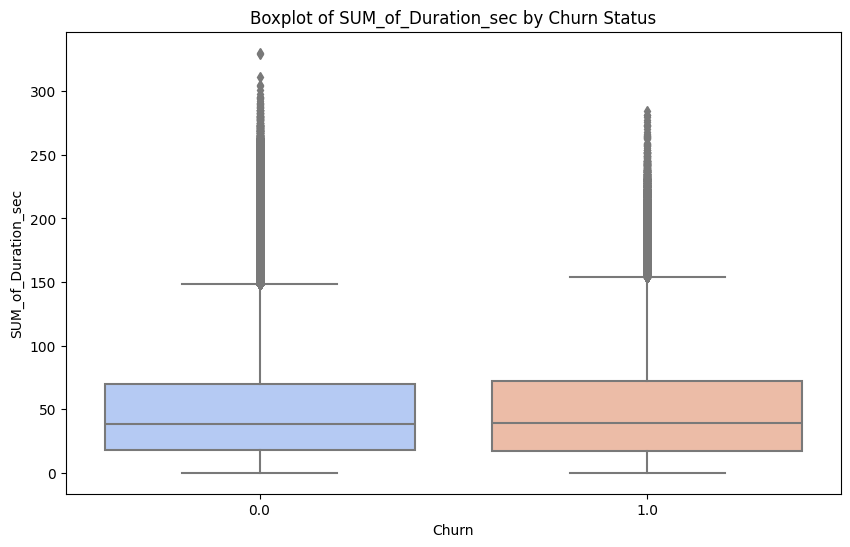

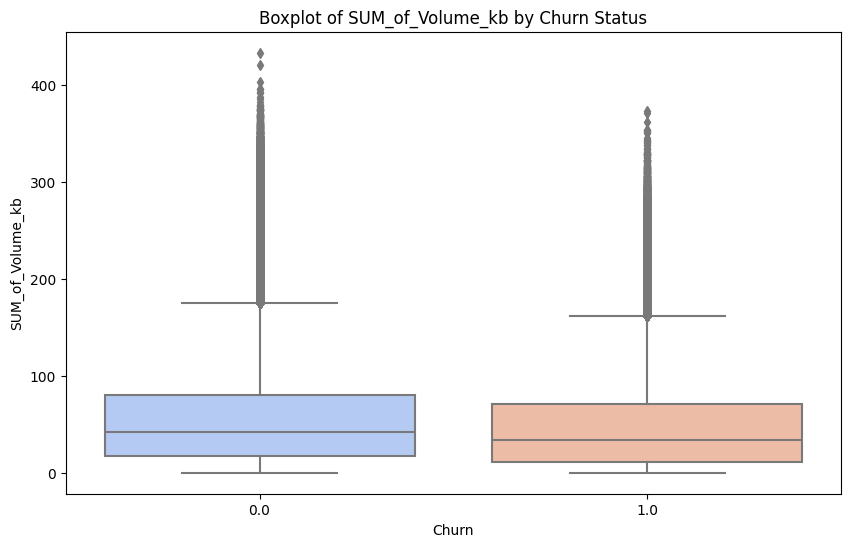

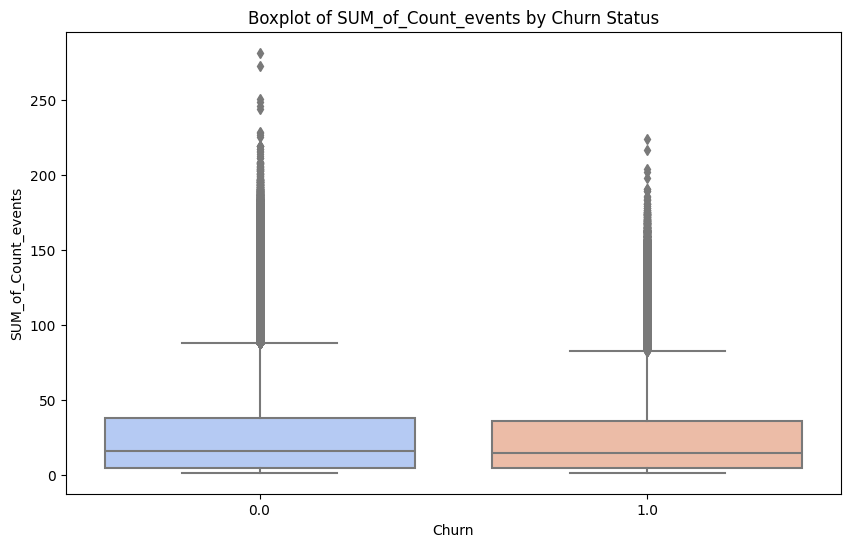

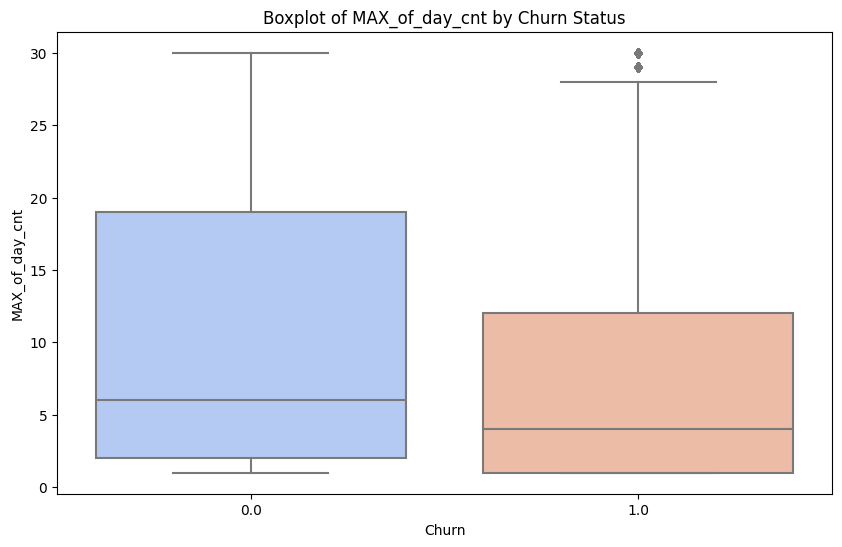

In [125]:
import seaborn as sns

for column in activ_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="target", y=column, data=df_train_dpi, palette="coolwarm")
    plt.title(f"Boxplot of {column} by Churn Status")
    plt.xlabel("Churn")
    plt.ylabel(column)
    plt.show()

In [121]:
# Some application which are used only by churned users

churn_counts = df_train_dpi.groupby(["Application", "target"]).size().unstack(fill_value=0)

result = churn_counts[churn_counts[1] > churn_counts[0]]

result

target,0.0,1.0
Application,,
163,0,1
1138,0,1
1148,0,1
2007,0,1


/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


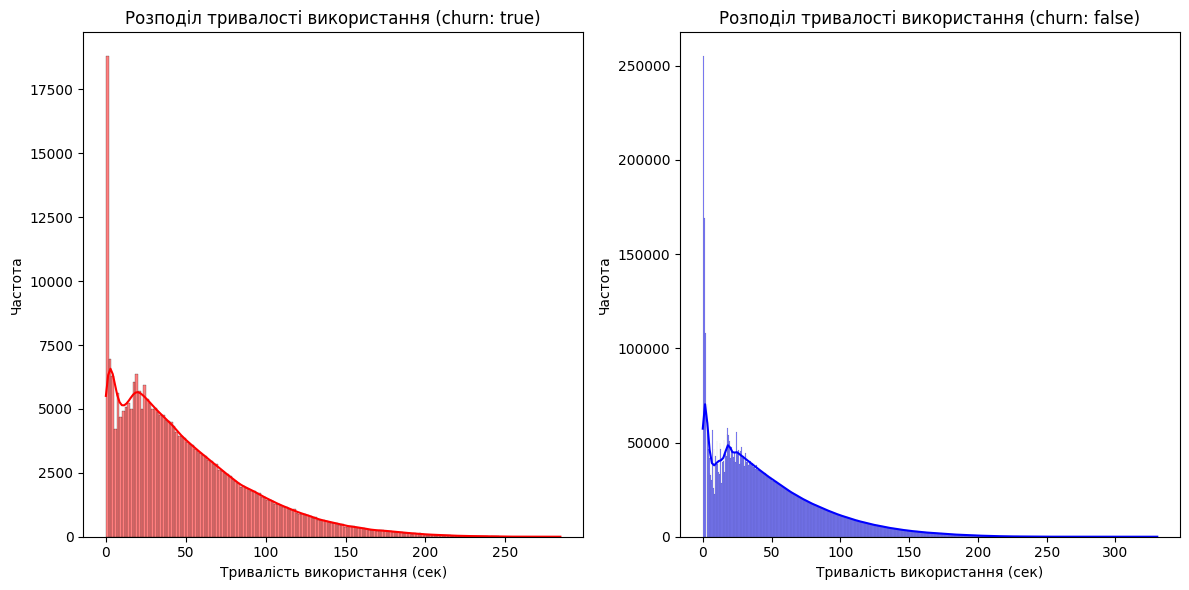

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


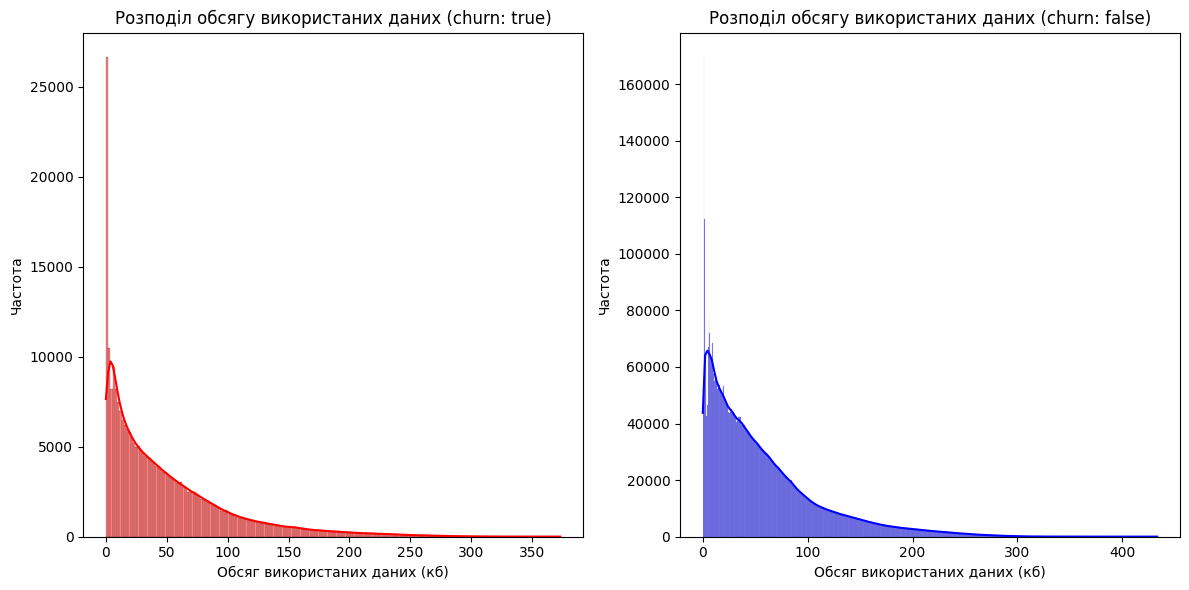

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


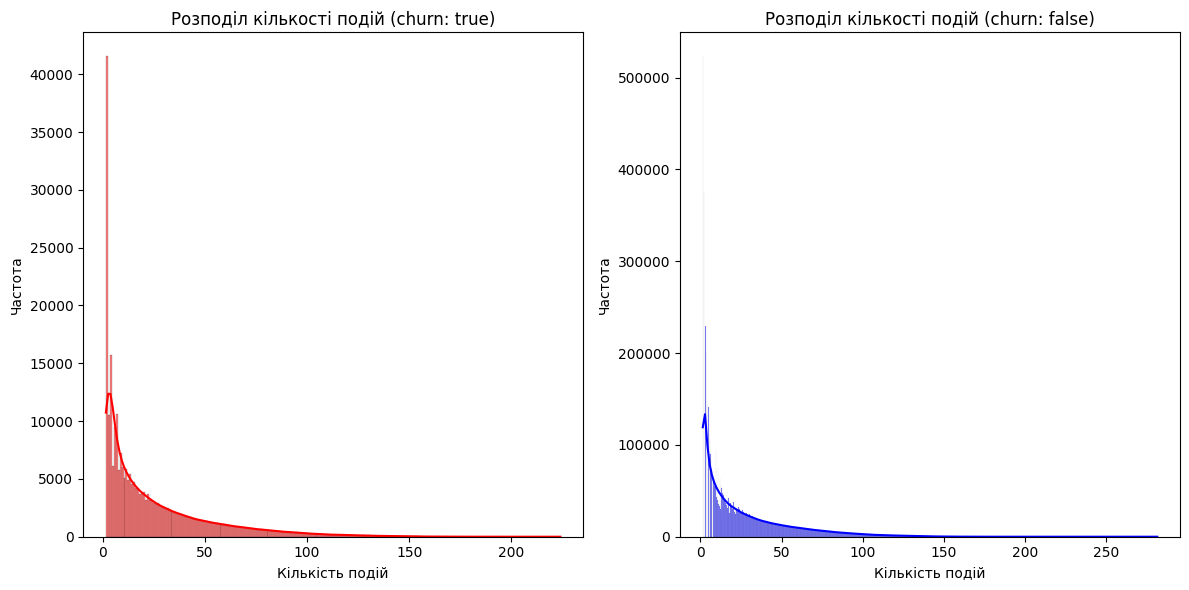

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


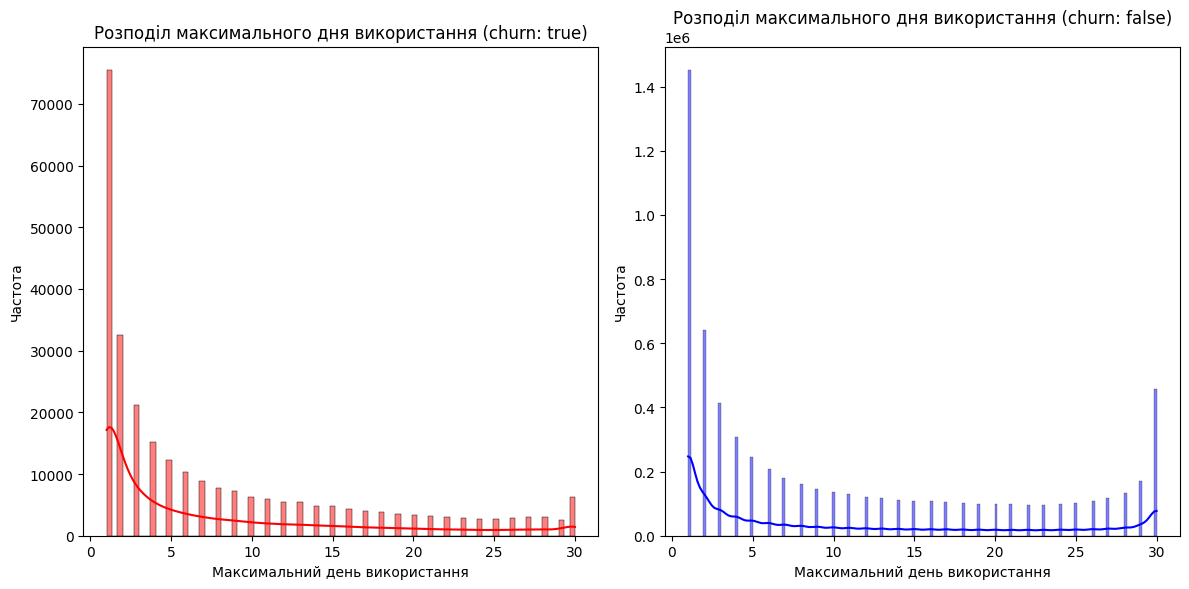

In [128]:
churn_true = df_train_dpi[df_train_dpi["target"] == 1]
churn_false = df_train_dpi[df_train_dpi["target"] == 0]

# Візуалізація порівняння

# Розподіл тривалості використання
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(churn_true["SUM_of_Duration_sec"], kde=True, color="red", label="churn: true")
plt.title("Розподіл тривалості використання (churn: true)")
plt.xlabel("Тривалість використання (сек)")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
sns.histplot(churn_false["SUM_of_Duration_sec"], kde=True, color="blue", label="churn: false")
plt.title("Розподіл тривалості використання (churn: false)")
plt.xlabel("Тривалість використання (сек)")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

# Розподіл обсягу використаних даних
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(churn_true["SUM_of_Volume_kb"], kde=True, color="red", label="churn: true")
plt.title("Розподіл обсягу використаних даних (churn: true)")
plt.xlabel("Обсяг використаних даних (кб)")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
sns.histplot(churn_false["SUM_of_Volume_kb"], kde=True, color="blue", label="churn: false")
plt.title("Розподіл обсягу використаних даних (churn: false)")
plt.xlabel("Обсяг використаних даних (кб)")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

# Розподіл кількості подій
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(churn_true["SUM_of_Count_events"], kde=True, color="red", label="churn: true")
plt.title("Розподіл кількості подій (churn: true)")
plt.xlabel("Кількість подій")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
sns.histplot(churn_false["SUM_of_Count_events"], kde=True, color="blue", label="churn: false")
plt.title("Розподіл кількості подій (churn: false)")
plt.xlabel("Кількість подій")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

# Розподіл максимального дня використання
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(churn_true["MAX_of_day_cnt"], kde=True, color="red", label="churn: true")
plt.title("Розподіл максимального дня використання (churn: true)")
plt.xlabel("Максимальний день використання")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
sns.histplot(churn_false["MAX_of_day_cnt"], kde=True, color="blue", label="churn: false")
plt.title("Розподіл максимального дня використання (churn: false)")
plt.xlabel("Максимальний день використання")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

In [132]:
activ_columns = ["SUM_of_Duration_sec", "SUM_of_Volume_kb", "SUM_of_Count_events", "MAX_of_day_cnt"]

df_train_dpi_groupped_by_abon = df_train_dpi.groupby("abon_id")[activ_columns].sum()

df_train_dpi_groupped_by_abon["target"] = df_train_dpi.groupby("abon_id")["target"].first()

churn_true = df_train_dpi_groupped_by_abon[df_train_dpi_groupped_by_abon["target"] == 1][activ_columns]
churn_false = df_train_dpi_groupped_by_abon[df_train_dpi_groupped_by_abon["target"] == 0][activ_columns]

print("-------Churn True------")
print(churn_true.describe())

print("-------Churn False------")
print(churn_false.describe())

-------Churn True------
       SUM_of_Duration_sec  SUM_of_Volume_kb  SUM_of_Count_events  \
count          6887.000000       6887.000000          6887.000000   
mean           1979.013796       1969.757545          1001.273058   
std            1811.676307       2228.357573           948.371942   
min               0.000000          0.000000             1.480453   
25%             334.063632         90.706276           141.497027   
50%            1590.915852       1156.231914           784.760318   
75%            3124.264148       3287.850564          1604.173458   
max           13655.125360      14870.785647          6654.845333   

       MAX_of_day_cnt  
count     6887.000000  
mean       314.262669  
std        352.008807  
min          1.000000  
25%         42.000000  
50%        173.000000  
75%        496.000000  
max       2616.000000  
-------Churn False------
       SUM_of_Duration_sec  SUM_of_Volume_kb  SUM_of_Count_events  \
count        115201.000000     115201.000000

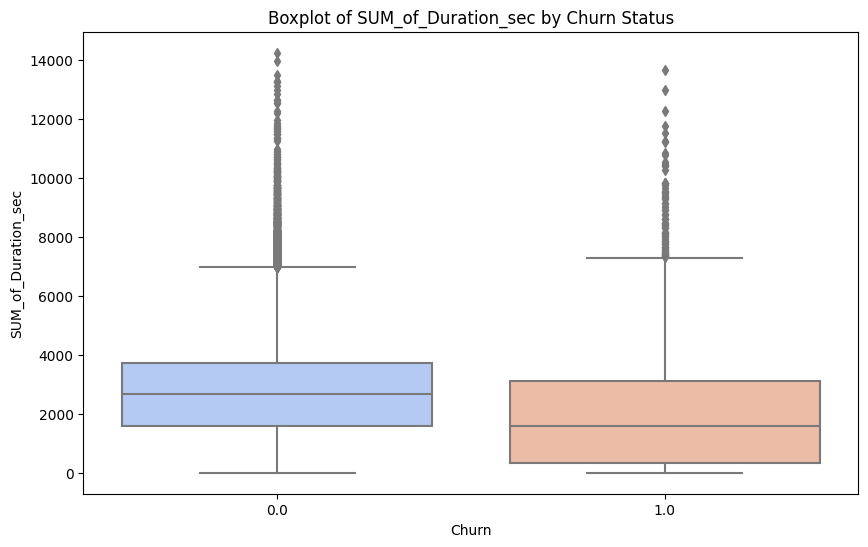

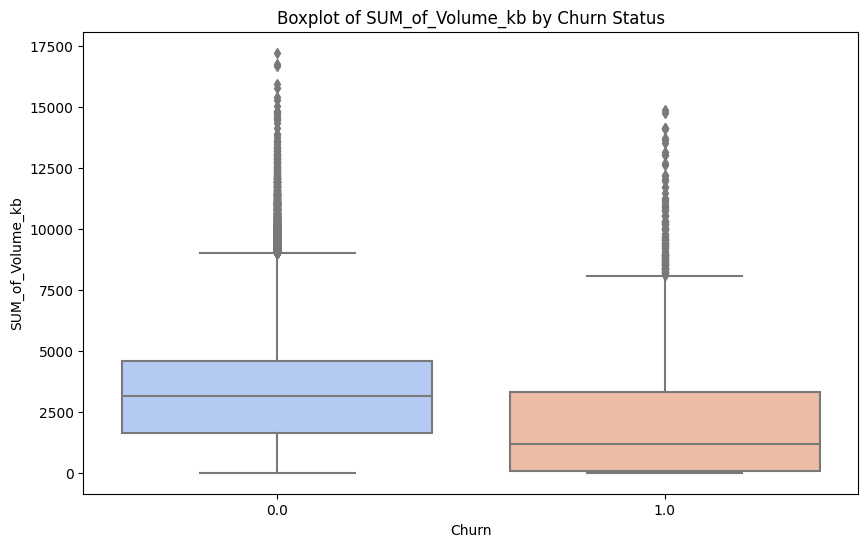

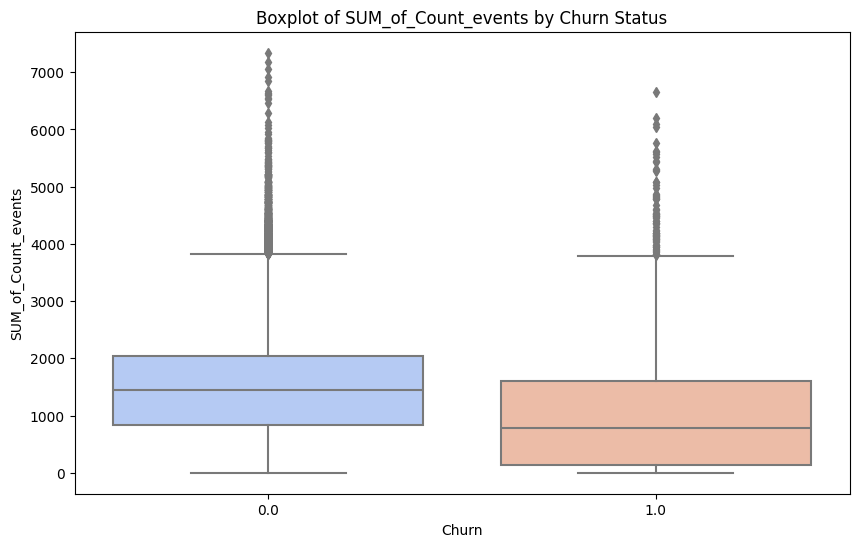

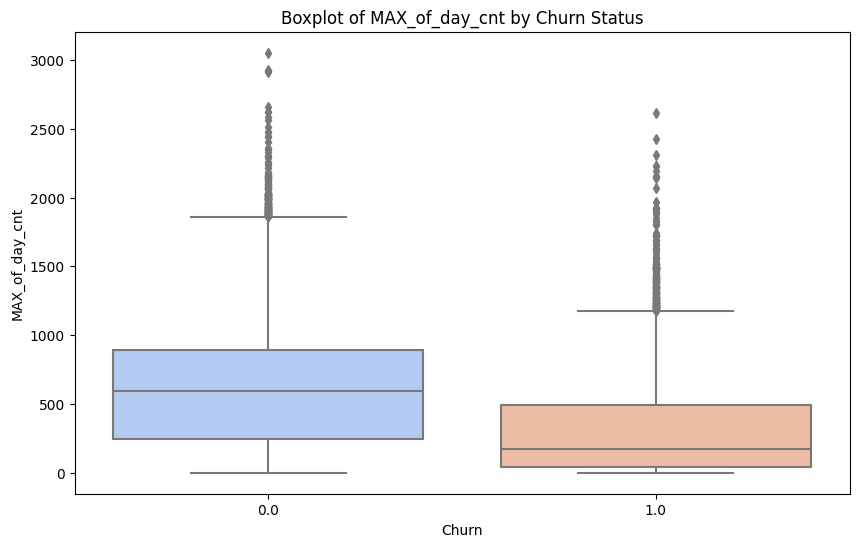

In [133]:
import seaborn as sns

for column in activ_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="target", y=column, data=df_train_dpi_groupped_by_abon, palette="coolwarm")
    plt.title(f"Boxplot of {column} by Churn Status")
    plt.xlabel("Churn")
    plt.ylabel(column)
    plt.show()

In [154]:
top_apps = []

for column in activ_columns:
    app_ids = df_train_dpi.groupby("Application")[column].mean().sort_values(ascending=False).head(10)
    top_apps += app_ids.index.to_list()
    print(column, app_ids.index.to_list())

top_apps = list(set(top_apps))

SUM_of_Duration_sec [258, 2563, 254, 1479, 850, 1193, 1414, 1500, 897, 677]
SUM_of_Volume_kb [2563, 381, 1929, 1500, 2574, 897, 258, 1527, 1446, 1414]
SUM_of_Count_events [598, 258, 381, 677, 2563, 850, 254, 716, 897, 1453]
MAX_of_day_cnt [541, 258, 677, 598, 850, 815, 877, 254, 690, 882]


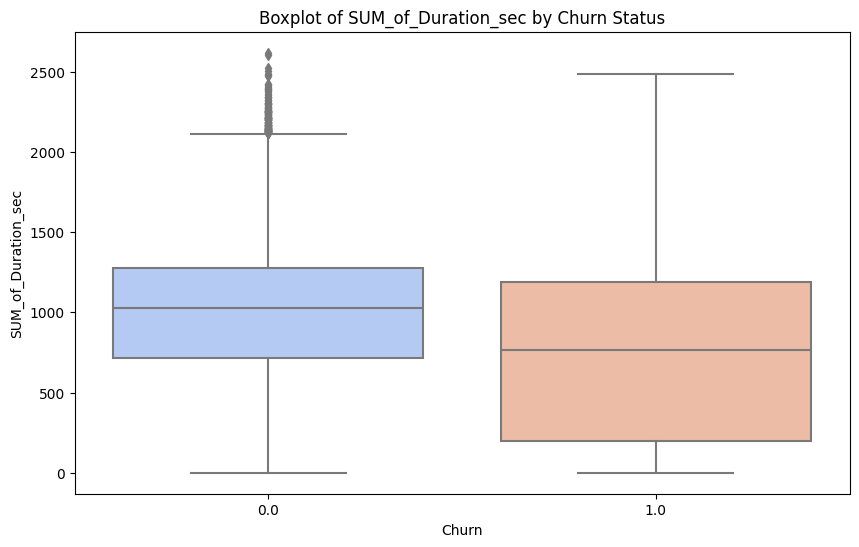

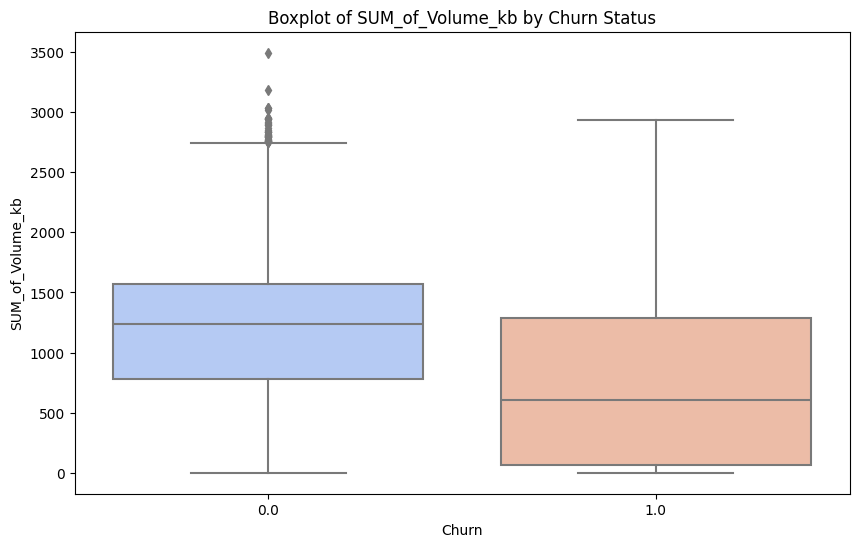

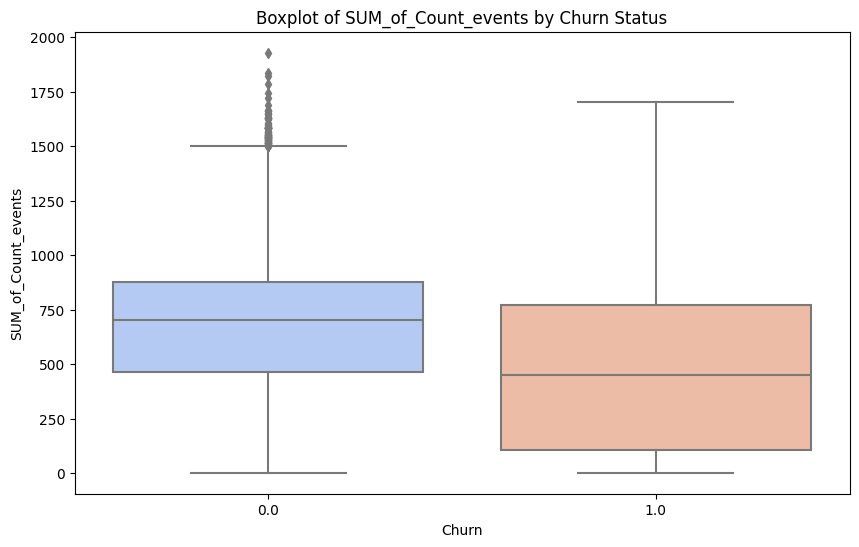

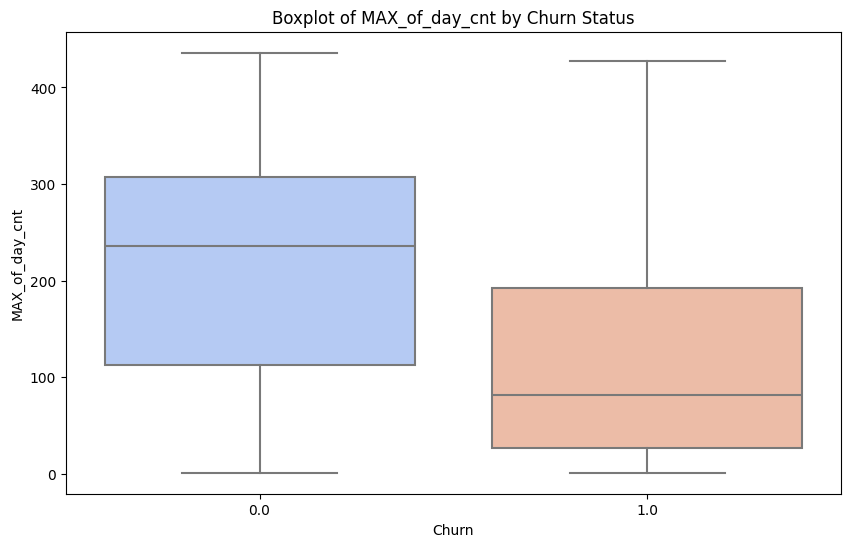

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

top_app_df_train_dpi = df_train_dpi[df_train_dpi["Application"].isin(top_apps)]
top_app_df_train_dpi_groupped_by_abon = top_app_df_train_dpi.groupby("abon_id")[activ_columns].sum()

# Додавання колонки target після групування
top_app_df_train_dpi_groupped_by_abon["target"] = top_app_df_train_dpi.groupby("abon_id")["target"].first()

for column in activ_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="target", y=column, data=top_app_df_train_dpi_groupped_by_abon, palette="coolwarm")
    plt.title(f"Boxplot of {column} by Churn Status")
    plt.xlabel("Churn")
    plt.ylabel(column)
    plt.show()